In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, regexp_replace, avg, when
from pyspark.sql.types import FloatType
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.style.use('ggplot')

In [3]:
spark = SparkSession.builder.appName("HealthSurveyAnalysis").getOrCreate()
file_path = "district_health_survey_updated_2024.csv"
df_spark = spark.read.csv(file_path, header=True, inferSchema=True)
print("Data Loaded Successfully!")
# df_spark.show(5)

Data Loaded Successfully!


In [4]:
selected_columns = [
    "State/UT",
    "Female population age 6 years and above who ever attended school (%)",
    "Population living in households that use an improved sanitation facility2 (%)",
    "Households using clean fuel for cooking3 (%)",
    "Women age 20-24 years married before age 18 years (%)",
    "Current Use of Family Planning Methods (Currently Married Women Age 15-49  years) - Any modern method6 (%)",
    "Children under 5 years who are stunted (height-for-age)18 (%)"
]
column_mapping = {
    "Female population age 6 years and above who ever attended school (%)": "School_Attendance",
    "Population living in households that use an improved sanitation facility2 (%)": "Improved_Sanitation",
    "Households using clean fuel for cooking3 (%)": "Clean_Fuel",
    "Women age 20-24 years married before age 18 years (%)": "Early_Marriage",
    "Current Use of Family Planning Methods (Currently Married Women Age 15-49  years) - Any modern method6 (%)": "Modern_FP",
    "Children under 5 years who are stunted (height-for-age)18 (%)": "Stunting"
}
df_clean = df_spark.select(["State/UT"] + selected_columns)
for old, new in column_mapping.items():
    df_clean = df_clean.withColumnRenamed(old, new)
df_clean.show(5)

+--------------------+--------------------+-----------------+-------------------+----------+--------------+---------+--------+
|            State/UT|            State/UT|School_Attendance|Improved_Sanitation|Clean_Fuel|Early_Marriage|Modern_FP|Stunting|
+--------------------+--------------------+-----------------+-------------------+----------+--------------+---------+--------+
|Andaman & Nicobar...|Andaman & Nicobar...|             78.0|               83.5|      56.9|         11.4 |     57.2|   21.6 |
|Andaman & Nicobar...|Andaman & Nicobar...|             82.7|               86.4|      61.3|         15.4 |     73.1|   27.0 |
|Andaman & Nicobar...|Andaman & Nicobar...|             84.7|               89.3|      91.9|         17.1 |     50.5|   21.1 |
|      Andhra Pradesh|      Andhra Pradesh|             60.0|               71.6|      74.7|         25.4 |     72.2|   19.7 |
|      Andhra Pradesh|      Andhra Pradesh|             56.0|               61.7|      60.3|         33.7 |    

In [5]:
def clean_and_cast_column(df, column_name):
    df = df.withColumn(column_name, regexp_replace(col(column_name), r"\(|\)", ""))
    df = df.withColumn(column_name, when(col(column_name) == "*", None).otherwise(col(column_name)))
    return df.withColumn(column_name, col(column_name).cast(FloatType()))
for c in column_mapping.values():
    df_clean = clean_and_cast_column(df_clean, c)
df_clean.show(5)

+--------------------+--------------------+-----------------+-------------------+----------+--------------+---------+--------+
|            State/UT|            State/UT|School_Attendance|Improved_Sanitation|Clean_Fuel|Early_Marriage|Modern_FP|Stunting|
+--------------------+--------------------+-----------------+-------------------+----------+--------------+---------+--------+
|Andaman & Nicobar...|Andaman & Nicobar...|             78.0|               83.5|      56.9|          11.4|     57.2|    21.6|
|Andaman & Nicobar...|Andaman & Nicobar...|             82.7|               86.4|      61.3|          15.4|     73.1|    27.0|
|Andaman & Nicobar...|Andaman & Nicobar...|             84.7|               89.3|      91.9|          17.1|     50.5|    21.1|
|      Andhra Pradesh|      Andhra Pradesh|             60.0|               71.6|      74.7|          25.4|     72.2|    19.7|
|      Andhra Pradesh|      Andhra Pradesh|             56.0|               61.7|      60.3|          33.7|    

In [6]:
df_state_avg = df_clean.groupBy("State/UT").agg(
    avg("School_Attendance").alias("Avg_School_Attendance"),
    avg("Improved_Sanitation").alias("Avg_Improved_Sanitation"),
    avg("Clean_Fuel").alias("Avg_Clean_Fuel"),
    avg("Early_Marriage").alias("Avg_Early_Marriage"),
    avg("Modern_FP").alias("Avg_Modern_FP"),
    avg("Stunting").alias("Avg_Stunting")
).sort("State/UT")
print("State-wise Aggregated Data (Top 5):")
df_state_avg.show(5)

State-wise Aggregated Data (Top 5):
+--------------------+---------------------+-----------------------+-----------------+------------------+------------------+------------------+
|            State/UT|Avg_School_Attendance|Avg_Improved_Sanitation|   Avg_Clean_Fuel|Avg_Early_Marriage|     Avg_Modern_FP|      Avg_Stunting|
+--------------------+---------------------+-----------------------+-----------------+------------------+------------------+------------------+
|        Lakshadweep |    73.16896583294046|       68.5586206501928| 49.5655172611105| 21.53793094898092|  43.9655175373472|   34.175862016349|
|Andaman & Nicobar...|    72.62249946594238|      63.08750009536743|54.14000005722046| 17.28999991416931|47.824999928474426| 32.14249973297119|
|      Andhra Pradesh|    73.61489340599547|      63.81063867122569|61.95531895820131| 23.76595745695398| 54.31914877384267|31.682978812684404|
|   Arunachal Pradesh|    70.86111104046857|      68.16111098395453|53.33703710414745|19.37592596036

In [7]:
df_state_avg_pd = df_state_avg.toPandas()
df_districts_pd = df_clean.toPandas()
print("Converted to Pandas DataFrames")
display(df_state_avg_pd.head())

Converted to Pandas DataFrames


,State/UT,Avg_School_Attendance,Avg_Improved_Sanitation,Avg_Clean_Fuel,Avg_Early_Marriage,Avg_Modern_FP,Avg_Stunting
0,Lakshadweep,73.168966,68.558621,49.565517,21.537931,43.965518,34.175862
1,Andaman & Nicobar Islands,72.622499,63.087500,54.140000,17.290000,47.825000,32.142500
2,Andhra Pradesh,73.614893,63.810639,61.955319,23.765957,54.319149,31.682979
3,Arunachal Pradesh,70.861111,68.161111,53.337037,19.375926,50.355556,30.694445
4,Assam,75.339655,69.650000,50.975862,25.087931,46.834483,34.794828


C:\Users\Nithin Reddy\AppData\Local\Temp\ipykernel_1728\3612744721.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="State/UT", y="Avg_School_Attendance", data=top_10_school, palette="viridis")


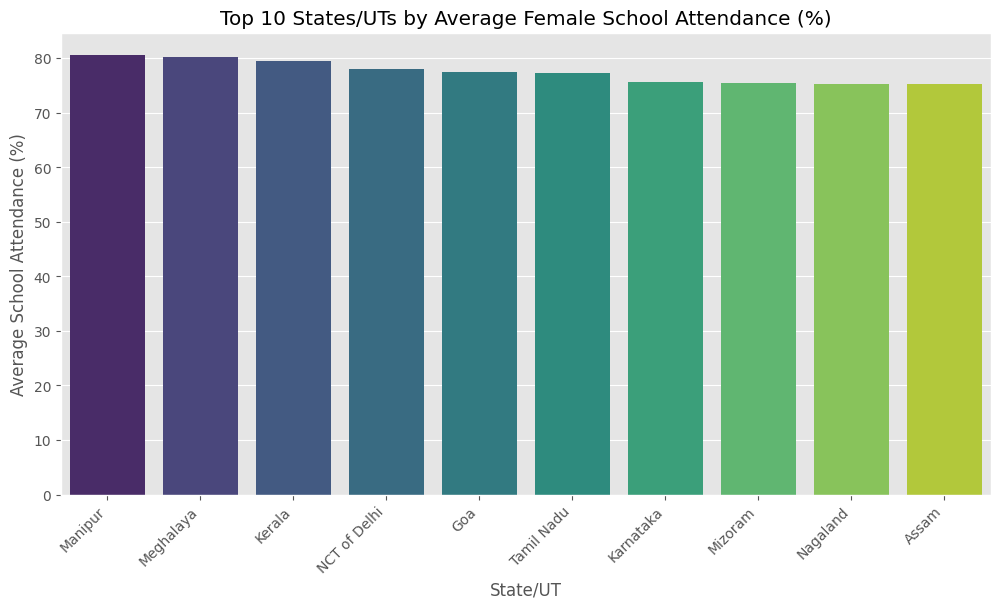

,State/UT,Avg_School_Attendance,Avg_Improved_Sanitation,Avg_Clean_Fuel,Avg_Early_Marriage,Avg_Modern_FP,Avg_Stunting
20,Manipur,80.662963,70.374074,53.177778,19.085185,37.188889,29.414815
21,Meghalaya,80.214706,68.829412,47.664706,17.094118,45.214706,37.061765
16,Kerala,79.504166,72.177083,56.289584,16.733333,45.368750,30.652083
23,NCT of Delhi,78.097222,67.688889,64.944445,16.819444,48.283333,32.002778
9,Goa,77.455556,69.285185,58.988888,20.462963,42.514815,33.214815
30,Tamil Nadu,77.272857,68.621429,61.852857,15.634286,53.197143,30.525714
15,Karnataka,75.574242,67.286364,59.745455,21.484849,50.803031,33.813636
22,Mizoram,75.529546,72.870454,62.090909,17.172727,46.838636,31.881818
24,Nagaland,75.340625,74.140625,40.981250,15.715625,46.018750,32.881250
4,Assam,75.339655,69.650000,50.975862,25.087931,46.834483,34.794828


In [8]:
top_10_school = df_state_avg_pd.sort_values(by="Avg_School_Attendance", ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x="State/UT", y="Avg_School_Attendance", data=top_10_school, palette="viridis")
plt.title("Top 10 States/UTs by Average Female School Attendance (%)")
plt.xlabel("State/UT")
plt.ylabel("Average School Attendance (%)")
plt.xticks(rotation=45, ha='right')
plt.show()
display(top_10_school)

C:\Users\Nithin Reddy\AppData\Local\Temp\ipykernel_1728\1399592671.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="State/UT", y="Avg_Stunting", data=top_10_stunting, palette="magma")


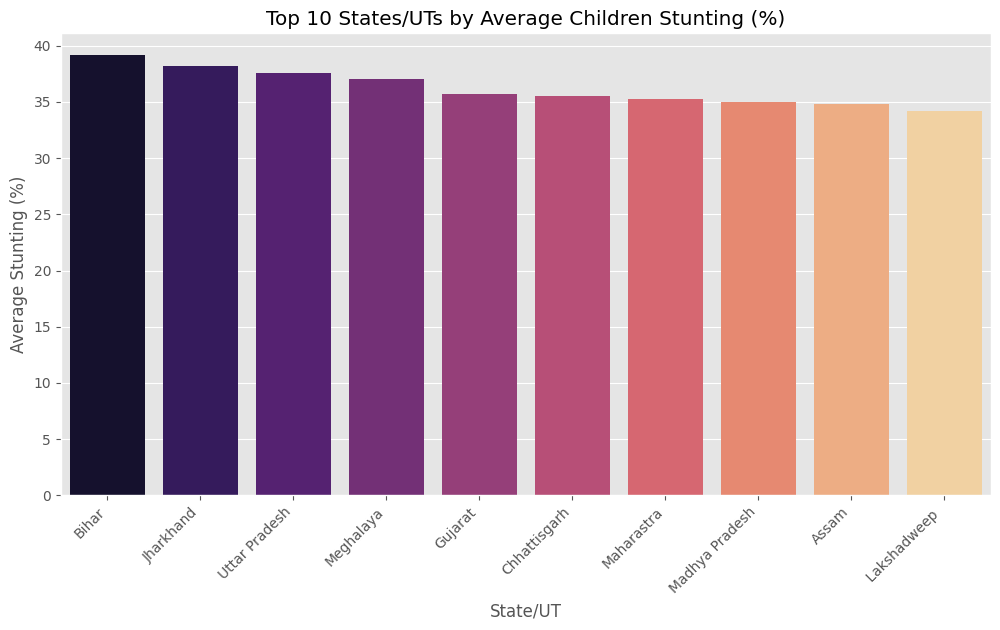

,State/UT,Avg_School_Attendance,Avg_Improved_Sanitation,Avg_Clean_Fuel,Avg_Early_Marriage,Avg_Modern_FP,Avg_Stunting
5,Bihar,66.686363,57.330303,40.718182,31.910606,45.483333,39.143939
14,Jharkhand,67.453333,59.464444,37.111111,25.771111,51.182222,38.213333
33,Uttar Pradesh,69.371000,69.391000,46.738000,18.358000,45.285000,37.598000
21,Meghalaya,80.214706,68.829412,47.664706,17.094118,45.214706,37.061765
10,Gujarat,69.977586,67.077586,58.500000,21.291379,49.975862,35.675862
7,Chhattisgarh,68.158621,67.189655,40.708621,18.946552,50.456897,35.486207
19,Maharastra,74.313333,69.881667,62.236667,21.006667,56.810000,35.278333
18,Madhya Pradesh,68.686487,62.767568,41.313514,22.798649,59.955405,35.022973
4,Assam,75.339655,69.650000,50.975862,25.087931,46.834483,34.794828
0,Lakshadweep,73.168966,68.558621,49.565517,21.537931,43.965518,34.175862


In [9]:
top_10_stunting = df_state_avg_pd.sort_values(by="Avg_Stunting", ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x="State/UT", y="Avg_Stunting", data=top_10_stunting, palette="magma")
plt.title("Top 10 States/UTs by Average Children Stunting (%)")
plt.xlabel("State/UT")
plt.ylabel("Average Stunting (%)")
plt.xticks(rotation=45, ha='right')
plt.show()
display(top_10_stunting)

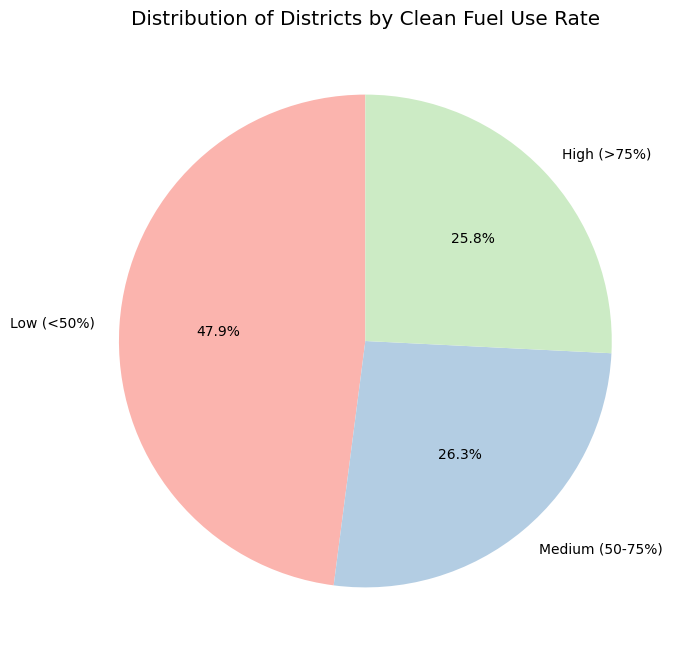

,District Count
Clean_Fuel_Category,
Low (<50%),818
Medium (50-75%),448
High (>75%),440


In [10]:
df_districts_pd['Clean_Fuel_Category'] = pd.cut(
    df_districts_pd['Clean_Fuel'],
    bins=[0, 50, 75, 100],
    labels=['Low (<50%)', 'Medium (50-75%)', 'High (>75%)'],
    right=False
)
clean_fuel_counts = df_districts_pd['Clean_Fuel_Category'].value_counts(dropna=True)
plt.figure(figsize=(8, 8))
plt.pie(clean_fuel_counts, labels=clean_fuel_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Pastel1"))
plt.title("Distribution of Districts by Clean Fuel Use Rate")
plt.show()
display(clean_fuel_counts.to_frame("District Count"))

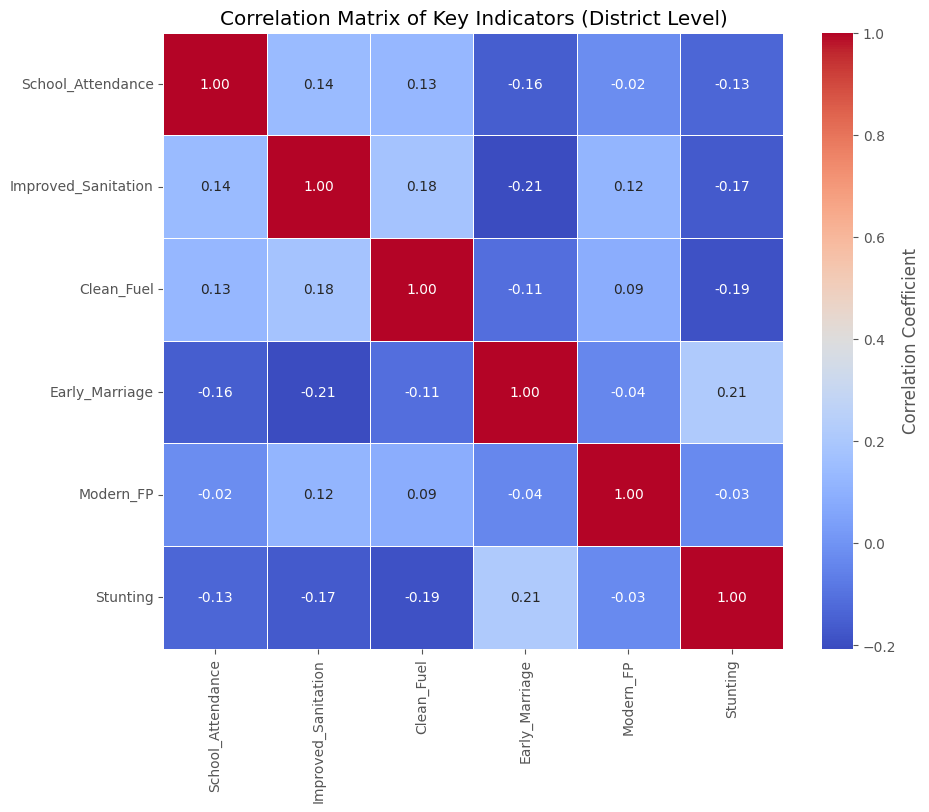

,School_Attendance,Improved_Sanitation,Clean_Fuel,Early_Marriage,Modern_FP,Stunting
School_Attendance,1.000000,0.140780,0.128150,-0.155827,-0.020595,-0.133295
Improved_Sanitation,0.140780,1.000000,0.177264,-0.206333,0.117693,-0.168224
Clean_Fuel,0.128150,0.177264,1.000000,-0.111727,0.086615,-0.188309
Early_Marriage,-0.155827,-0.206333,-0.111727,1.000000,-0.038640,0.213657
Modern_FP,-0.020595,0.117693,0.086615,-0.038640,1.000000,-0.027757
Stunting,-0.133295,-0.168224,-0.188309,0.213657,-0.027757,1.000000


In [11]:
corr_cols = ["School_Attendance", "Improved_Sanitation", "Clean_Fuel", "Early_Marriage", "Modern_FP", "Stunting"]
corr_matrix = df_districts_pd[corr_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5, cbar_kws={'label': 'Correlation Coefficient'})
plt.title("Correlation Matrix of Key Indicators (District Level)")
plt.show()
display(corr_matrix)

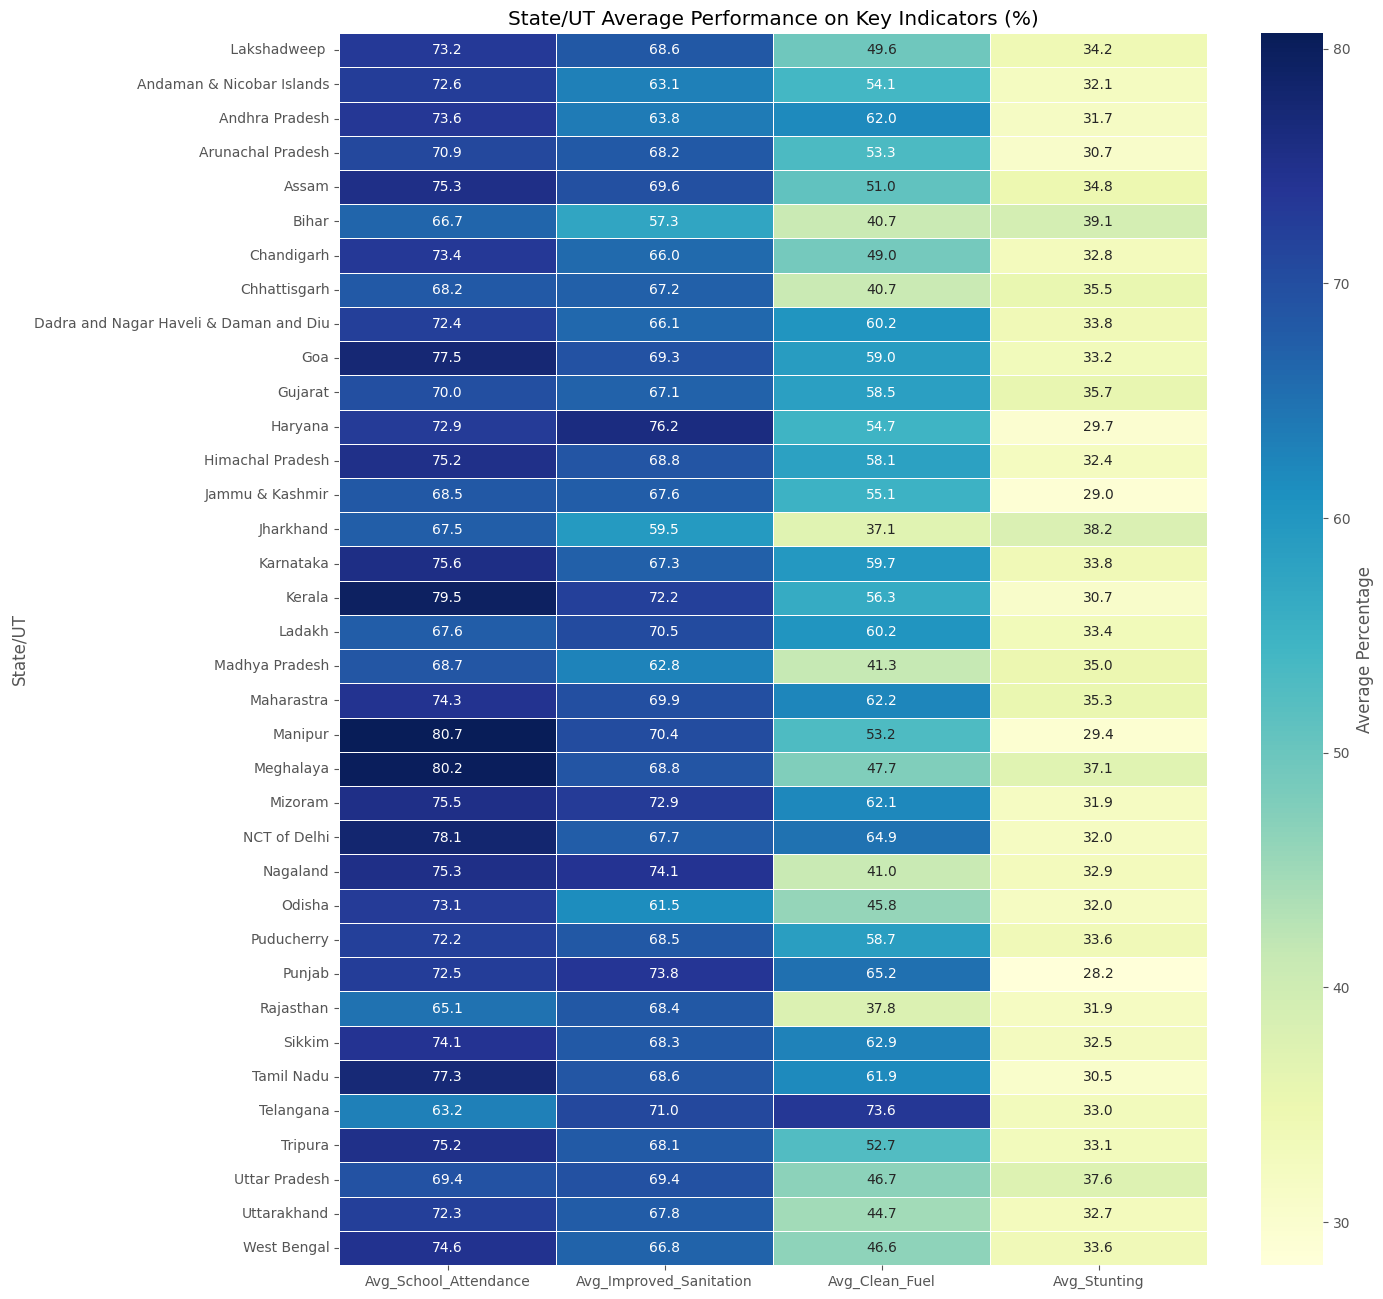

,Avg_School_Attendance,Avg_Improved_Sanitation,Avg_Clean_Fuel,Avg_Stunting
State/UT,,,,
Lakshadweep,73.168966,68.558621,49.565517,34.175862
Andaman & Nicobar Islands,72.622499,63.087500,54.140000,32.142500
Andhra Pradesh,73.614893,63.810639,61.955319,31.682979
Arunachal Pradesh,70.861111,68.161111,53.337037,30.694445
Assam,75.339655,69.650000,50.975862,34.794828
Bihar,66.686363,57.330303,40.718182,39.143939
Chandigarh,73.403333,65.980000,49.000000,32.796666
Chhattisgarh,68.158621,67.189655,40.708621,35.486207
Dadra and Nagar Haveli & Daman and Diu,72.372728,66.113636,60.181818,33.786364


In [12]:
heatmap_cols = ["Avg_School_Attendance", "Avg_Improved_Sanitation", "Avg_Clean_Fuel", "Avg_Stunting"]
df_heatmap_2 = df_state_avg_pd.set_index('State/UT')[heatmap_cols].fillna(0)
plt.figure(figsize=(14, 16))
sns.heatmap(df_heatmap_2, annot=True, cmap="YlGnBu", fmt=".1f", linewidths=.5, cbar_kws={'label': 'Average Percentage'})
plt.title("State/UT Average Performance on Key Indicators (%)")
plt.show()
display(df_heatmap_2)

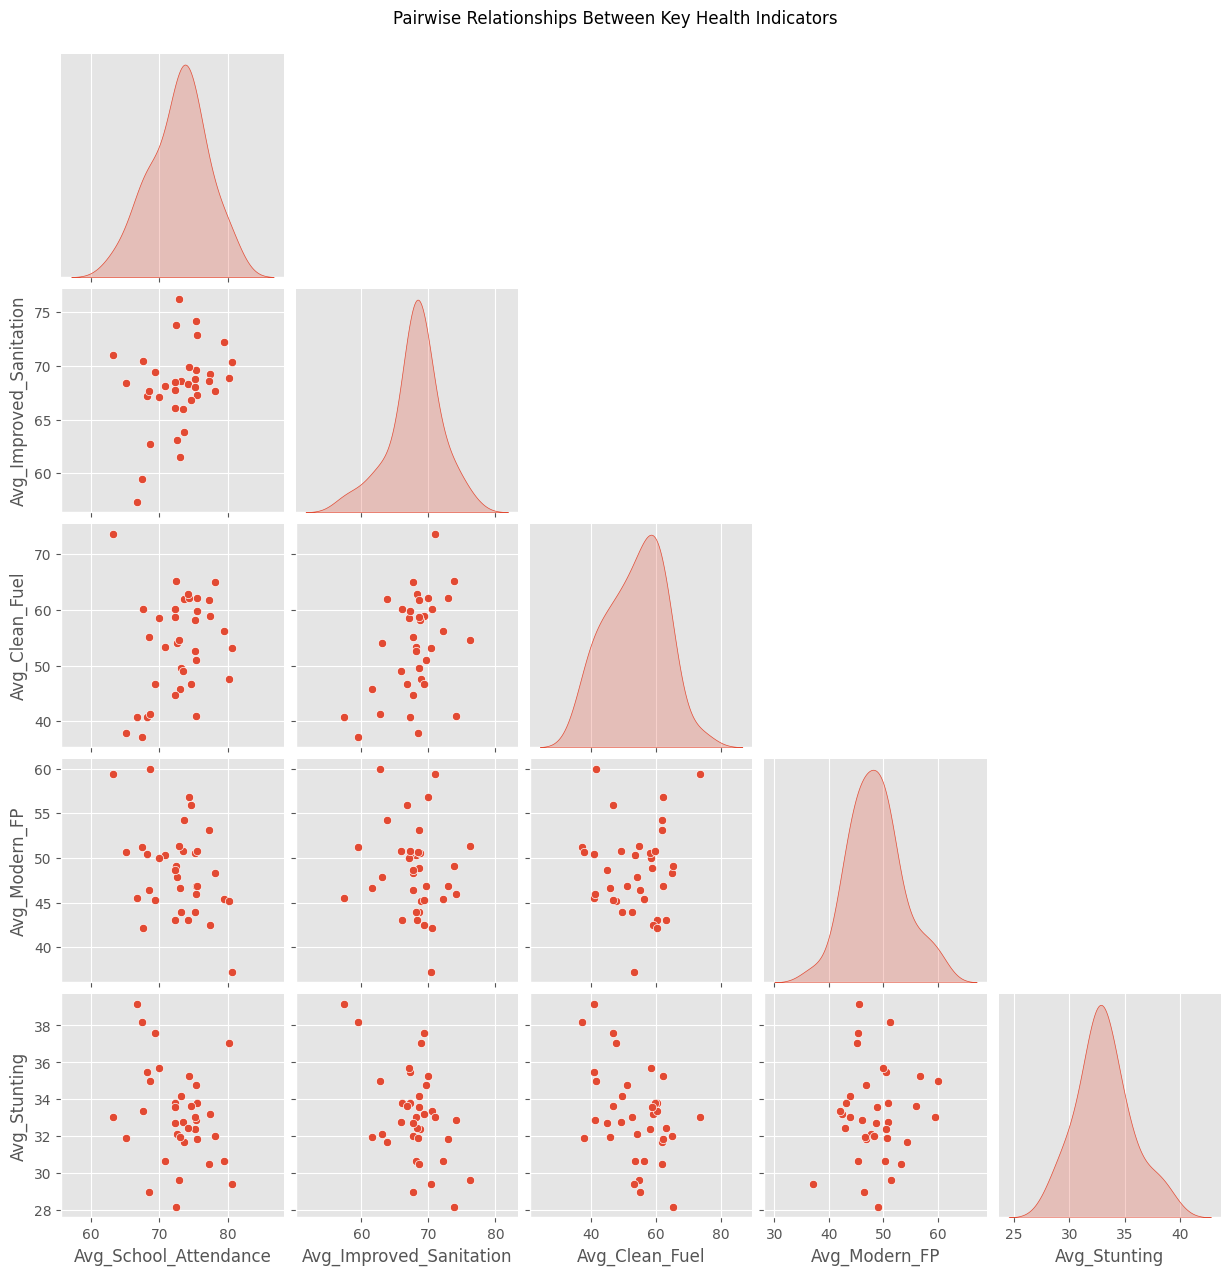

In [13]:
sns.pairplot(
    df_state_avg_pd[[
        "Avg_School_Attendance", 
        "Avg_Improved_Sanitation", 
        "Avg_Clean_Fuel", 
        "Avg_Modern_FP", 
        "Avg_Stunting"
    ]],
    diag_kind="kde",
    corner=True
)
plt.suptitle("Pairwise Relationships Between Key Health Indicators", y=1.02)
plt.show()

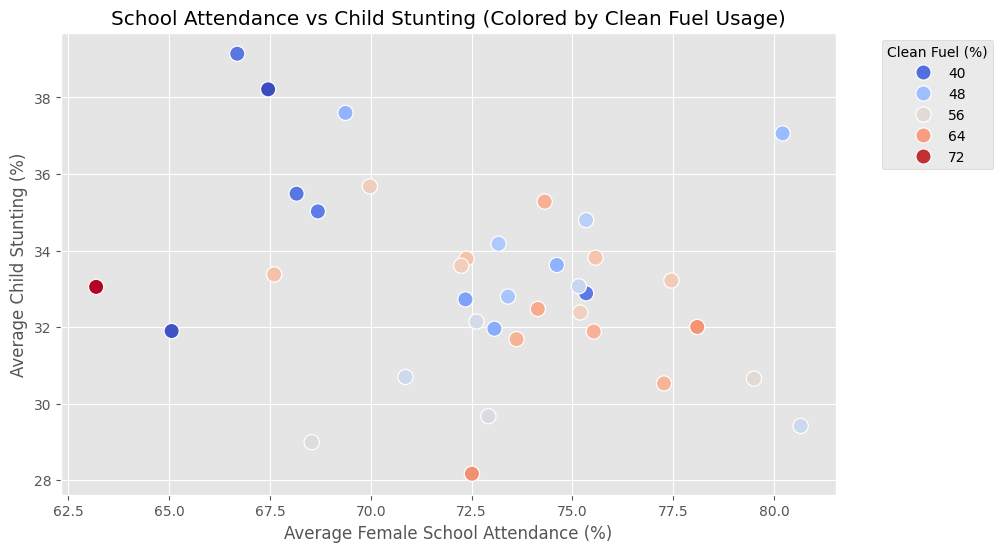

In [14]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_state_avg_pd,
    x="Avg_School_Attendance",
    y="Avg_Stunting",
    hue="Avg_Clean_Fuel",
    palette="coolwarm",
    s=120
)
plt.title("School Attendance vs Child Stunting (Colored by Clean Fuel Usage)")
plt.xlabel("Average Female School Attendance (%)")
plt.ylabel("Average Child Stunting (%)")
plt.legend(title="Clean Fuel (%)", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [15]:
spark.stop()
print("Spark Session Stopped.")

Spark Session Stopped.
